In [1]:
# Part 1: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# make plots appear inline (if you’re in Jupyter)
%matplotlib inline

In [2]:
# Part 2: load raw CSV (must have downloaded AB_NYC_2019.csv into same folder)
df = pd.read_csv("AB_NYC_2019.csv")

# show top 5 rows
print(df.head())

# shape and null counts
print("\nRows, cols:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

In [5]:
# Part 3: drop and impute
df = df.drop(columns=["name", "host_name", "last_review"])

# fill missing review rates with zero
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# remove free or absurdly expensive listings
df = df[df["price"].between(1, 999)]

# check new shape and any remaining nulls
print("After cleaning, shape:", df.shape)
print("Missing values now:\n", df.isnull().sum())

After cleaning, shape: (48586, 13)
Missing values now:
 id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


          price  minimum_nights  number_of_reviews  reviews_per_month  \
count  48586.00        48586.00           48586.00           48586.00   
mean     140.27            6.97              23.37               1.10   
std      112.90           20.28              44.65               1.60   
min       10.00            1.00               0.00               0.00   
25%       69.00            1.00               1.00               0.04   
50%      105.00            3.00               5.00               0.38   
75%      175.00            5.00              24.00               1.60   
max      999.00         1250.00             629.00              58.50   

       availability_365  
count          48586.00  
mean             112.37  
std              131.38  
min                0.00  
25%                0.00  
50%               44.00  
75%              225.00  
max              365.00  


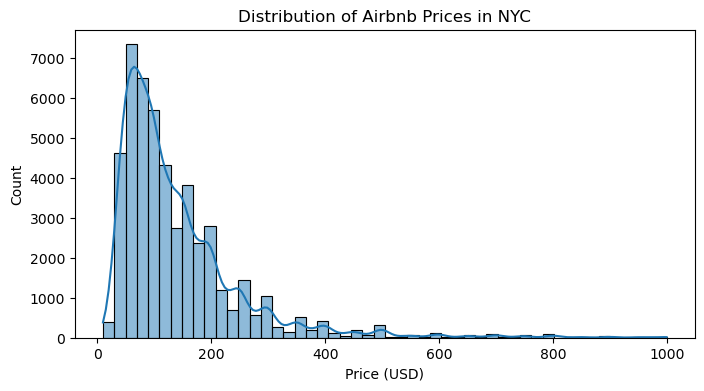

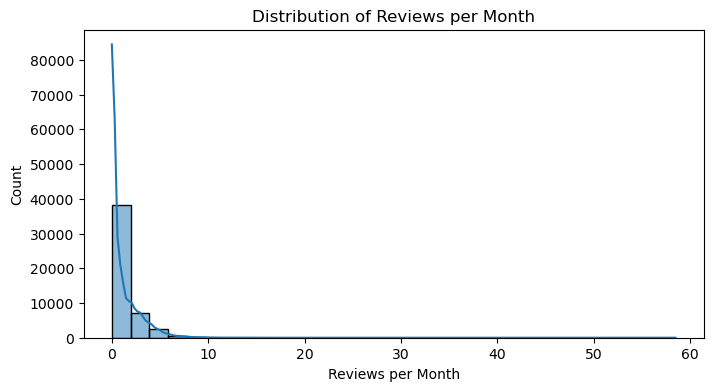

In [7]:
# Part 4: Quick EDA

# 1. Summary statistics
print(df[['price',
          'minimum_nights',
          'number_of_reviews',
          'reviews_per_month',
          'availability_365']].describe().round(2))

# 2. Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df.price, bins=50, kde=True)
plt.title("Distribution of Airbnb Prices in NYC")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

# 3. Reviews per month distribution
plt.figure(figsize=(8,4))
sns.histplot(df.reviews_per_month, bins=30, kde=True)
plt.title("Distribution of Reviews per Month")
plt.xlabel("Reviews per Month")
plt.ylabel("Count")
plt.show()

In [9]:
# Part 5: one-hot encode neighbourhood_group and room_type
df_enc = pd.get_dummies(
    df,
    columns=["neighbourhood_group","room_type"],
    drop_first=True
)

# show how many new columns you have
print("New shape after encoding:", df_enc.shape)
print("\nSample of encoded columns:")
print(df_enc.filter(regex="neighbourhood_group_|room_type_").head())


New shape after encoding: (48586, 17)

Sample of encoded columns:
   neighbourhood_group_Brooklyn  neighbourhood_group_Manhattan  \
0                          True                          False   
1                         False                           True   
2                         False                           True   
3                          True                          False   
4                         False                           True   

   neighbourhood_group_Queens  neighbourhood_group_Staten Island  \
0                       False                              False   
1                       False                              False   
2                       False                              False   
3                       False                              False   
4                       False                              False   

   room_type_Private room  room_type_Shared room  
0                    True                  False  
1                   False 

In [11]:
# Part 6a: pick the numeric + dummy features
base_feats = [
    "latitude","longitude","price","minimum_nights",
    "number_of_reviews","reviews_per_month",
    "calculated_host_listings_count","availability_365"
]
cat_feats = [
    c for c in df_enc.columns
    if c.startswith("neighbourhood_group_")
    or c.startswith("room_type_")
]
features = base_feats + cat_feats

X = df_enc[features]
print("Feature matrix shape:", X.shape)

# Part 6b: scale to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled feature matrix shape:", X_scaled.shape)


Feature matrix shape: (48586, 14)
Scaled feature matrix shape: (48586, 14)


X_scaled shape: (48586, 14)
k =  2   silhouette = 0.2361
k =  3   silhouette = 0.2908
k =  4   silhouette = 0.2918
k =  5   silhouette = 0.2997
k =  6   silhouette = 0.3138
k =  7   silhouette = 0.2628
k =  8   silhouette = 0.2711
k =  9   silhouette = 0.2808
k = 10   silhouette = 0.2800


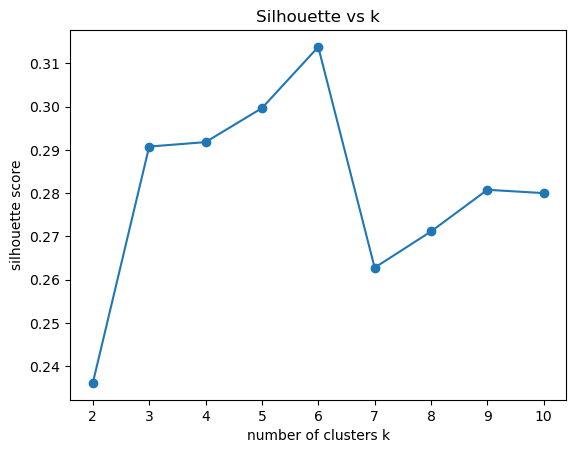

In [13]:
# --- Part 7: Silhouette scan for k — combined cell ---

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Sanity check: do we have X_scaled in memory?
try:
    print("X_scaled shape:", X_scaled.shape)
except NameError:
    raise NameError("X_scaled is not defined. Go back and run the scaling cell (Part 6) first.")

# Now compute and print
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k:2d}   silhouette = {score:.4f}")

# And plot
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("number of clusters k")
plt.ylabel("silhouette score")
plt.title("Silhouette vs k")
plt.show()


In [16]:
from sklearn.cluster import KMeans

# 1. Fit KMeans at k = 6
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 2. How many listings per cluster?
print(df['cluster'].value_counts().sort_index())


cluster
0    18300
1    19857
2     3705
3      715
4      370
5     5639
Name: count, dtype: int64


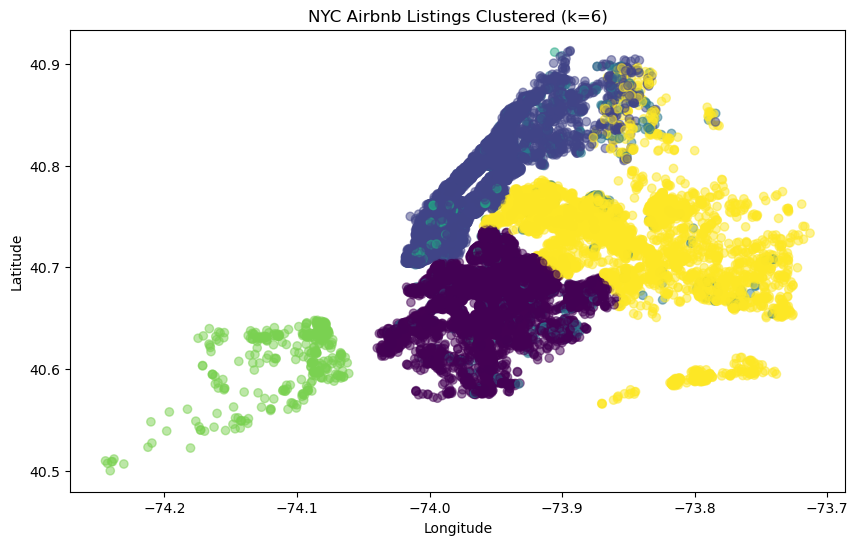

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df['longitude'],
    df['latitude'],
    c=df['cluster'],      # color by cluster label
    alpha=0.5
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("NYC Airbnb Listings Clustered (k=6)")
plt.show()


In [20]:
# Part 10: summary stats by cluster
cluster_summary = df.groupby('cluster')[
    ['price', 'number_of_reviews', 'availability_365']
].mean().round(2)

print(cluster_summary)


          price  number_of_reviews  availability_365
cluster                                             
0        116.94              13.73             92.71
1        173.97              12.06            102.58
2        125.67             138.86            170.97
3        266.27               2.25            287.24
4         96.15              31.19            199.32
5         93.82              20.80            144.23


<Figure size 800x500 with 0 Axes>

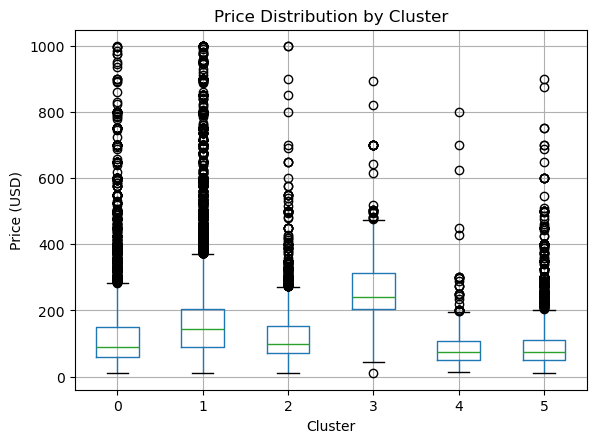

In [24]:
#Additional Analysis: Price Distribution by Cluster (boxplots)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df.boxplot(column='price', by='cluster')
plt.title("Price Distribution by Cluster")
plt.suptitle("")      # remove the automatic “Boxplot grouped by cluster” title
plt.xlabel("Cluster")
plt.ylabel("Price (USD)")
plt.show()


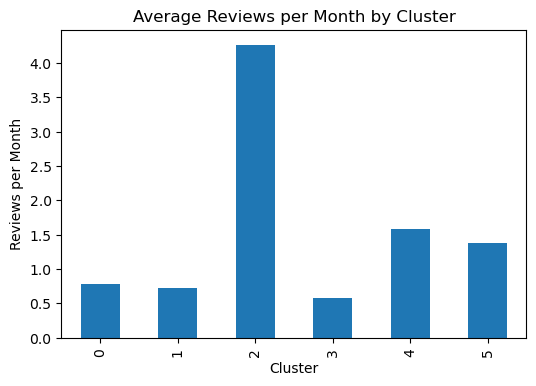

In [28]:
#Additional Analysis: Average Reviews per Month by Cluster (bar chart)

import matplotlib.pyplot as plt

cluster_rev = df.groupby('cluster')['reviews_per_month'].mean()
plt.figure(figsize=(6,4))
cluster_rev.plot(kind='bar')
plt.title("Average Reviews per Month by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Reviews per Month")
plt.show()

<Figure size 800x500 with 0 Axes>

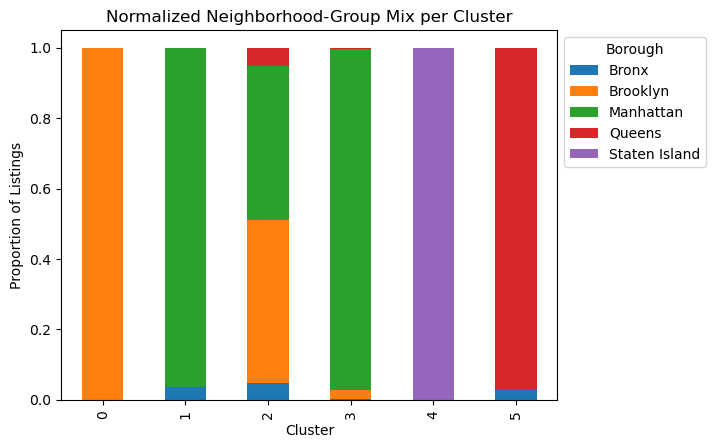

In [30]:
#Additional Analysis: Neighborhood-Group Composition per Cluster (stacked bar chart)
import pandas as pd
import matplotlib.pyplot as plt

# pull counts of each neighbourhood_group within each cluster
cross = pd.crosstab(df['cluster'], df['neighbourhood_group'])
cross_norm = cross.div(cross.sum(axis=1), axis=0)   # convert to proportions

plt.figure(figsize=(8,5))
cross_norm.plot(kind='bar', stacked=True)
plt.title("Normalized Neighborhood-Group Mix per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion of Listings")
plt.legend(title="Borough", bbox_to_anchor=(1,1))
plt.show()

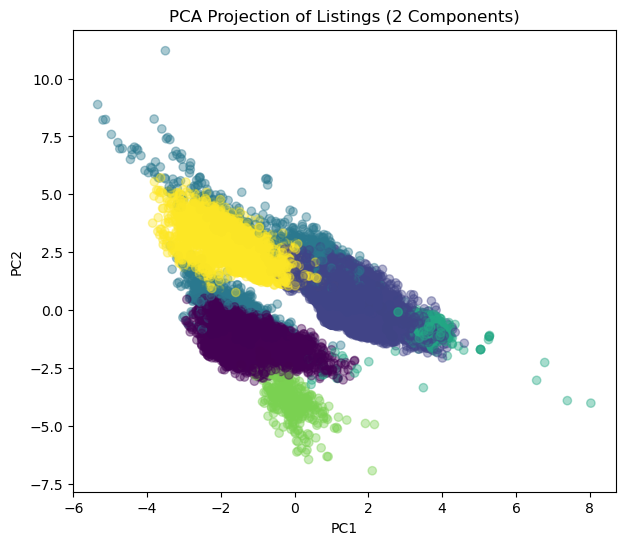

In [32]:
#Additional Analysis: PCA Projection of Listings (2D scatter)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(coords[:,0], coords[:,1], c=df['cluster'], alpha=0.4)
plt.title("PCA Projection of Listings (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

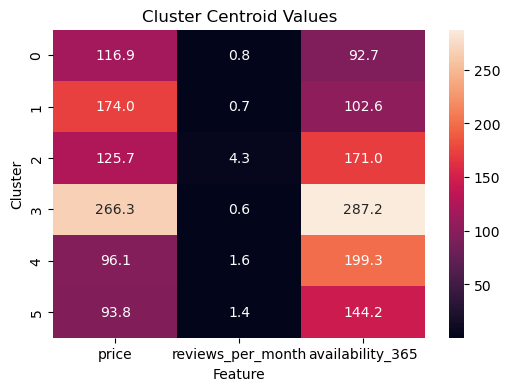

In [34]:
#Additional Analysis: Cluster Centroid Heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# compute centroids in the original feature space
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
centroids['cluster'] = range(len(centroids))

# pick a handful of key features to display
to_plot = ['price','reviews_per_month','availability_365']
cm = centroids.set_index('cluster')[to_plot]

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt=".1f")
plt.title("Cluster Centroid Values")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()
